In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

BATCH_SIZE = 4
#torch.manual_seed(42)

data_transform =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


        

train_dir = "./roofs"
# Use ImageFolder to create dataset(s)
my_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None)

class_names = my_data.classes
                                 

# Define the ratio of data split
train_ratio = 0.85  # 80% of data for training, 20% for testing
total_data = len(my_data)
train_size = int(train_ratio * total_data)
test_size = total_data - train_size

# Set random seed for reproducible split
generator = torch.Generator().manual_seed(32)

# Split the data into training and testing sets
train_data, test_data = random_split(my_data, [train_size, test_size], generator=generator)

# Create DataLoader for training and testing sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"{train_size=}")
print(f"{test_size=}")

train_size=88
test_size=16


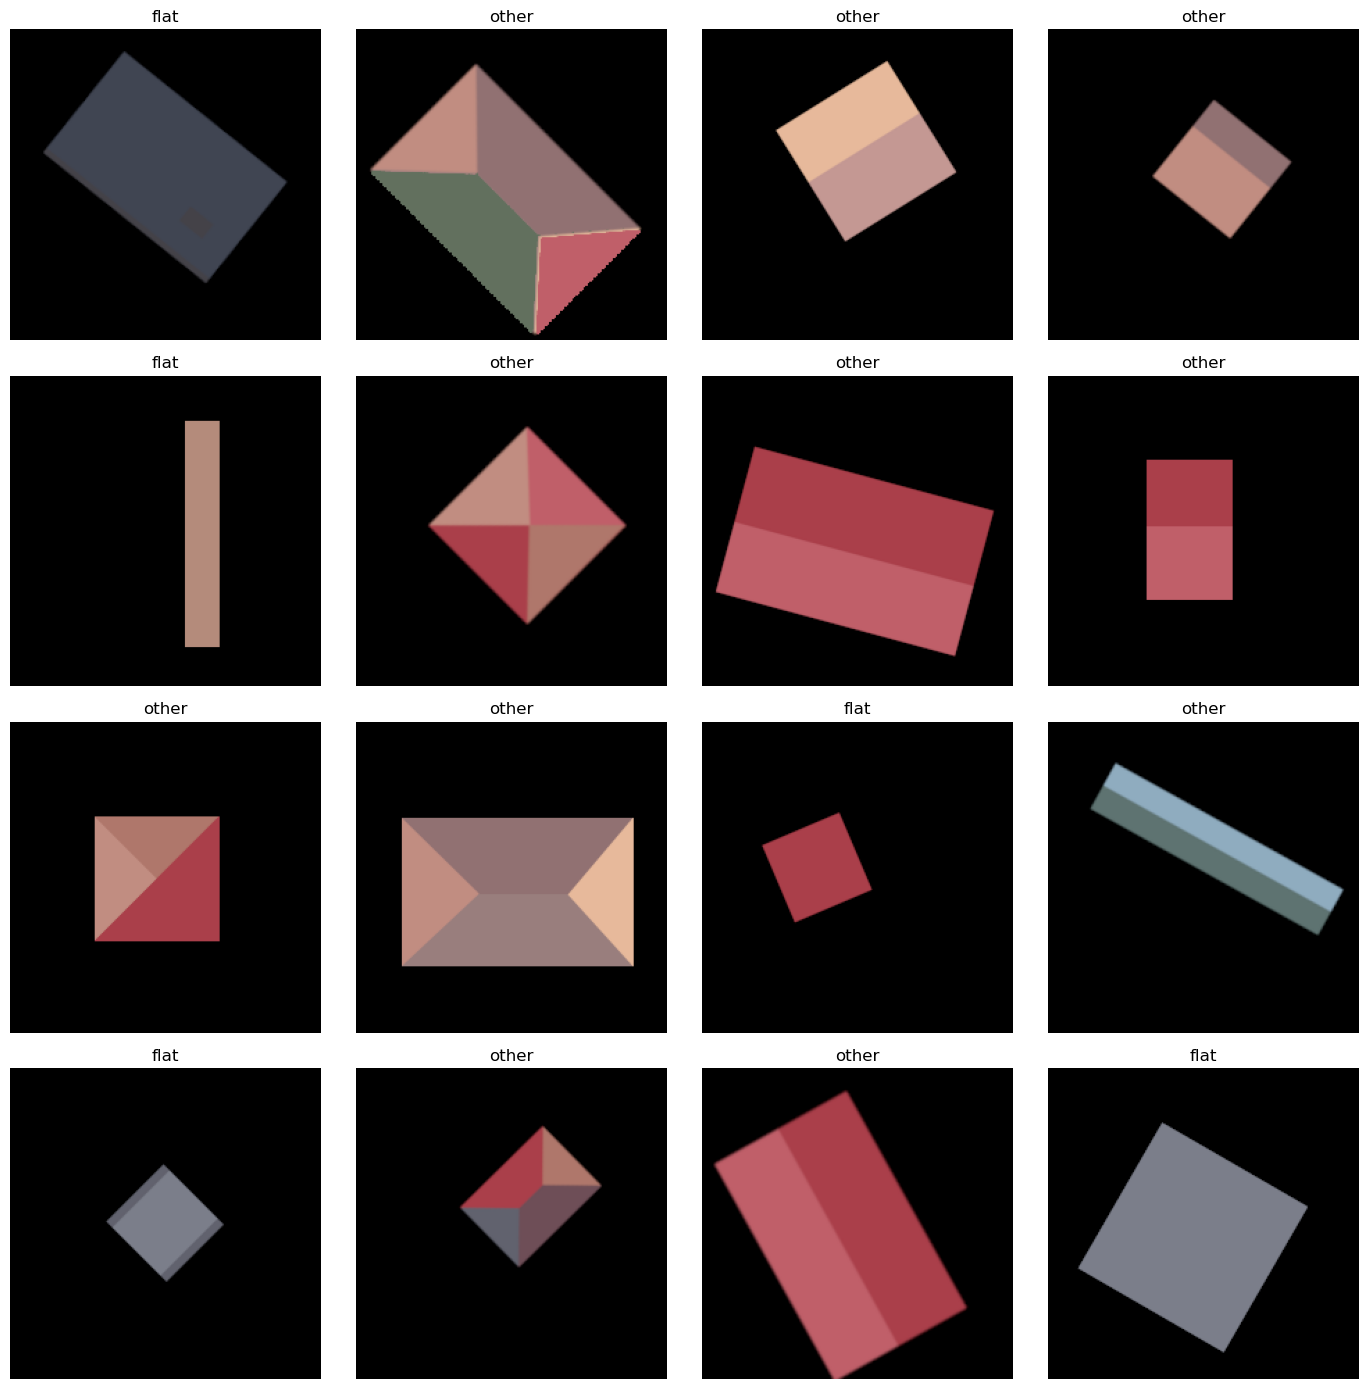

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Define the mean and standard deviation for the normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the inverse transformation to bring the image back to the original range
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# Function to apply inverse normalization and clip values
def inverse_normalize(img):
    img = img.permute(1, 2, 0)  # Rearrange dimensions for visualization
    img = (img * torch.tensor(std) + torch.tensor(mean)) * 255  # Inverse normalization and scale to [0, 255]
    img = img.clip(0, 255)  # Clip values to ensure they are within [0, 255]
    return img.to(torch.uint8).numpy()  # Convert to numpy array of uint8 type

# Select 16 random images and their labels
#indices = np.random.choice(len(my_data), 16, replace=False)
#images = [my_data[i][0] for i in indices]
#labels = [my_data[i][1] for i in indices]

# Extract images and labels from test_data
images = [item[0] for item in test_data]
labels = [item[1] for item in test_data]


# Plot the images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
for i, ax in enumerate(axes.flat):
    img = inverse_normalize(images[i])
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(class_names[labels[i]])
plt.tight_layout()
plt.show()


In [97]:
import torchvision.models as models
from torch import nn

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")


def set_seeds(seed: int=33):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def create_vgg16():
    model = models.vgg16(weights='DEFAULT').to(device)
    # Freeze all feture extr. layers
    for param in model.features.parameters():
        #print(param)
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=25088,
                out_features=2)).to(device)
    
    model.name = "vgg_16"
    print(f"[INFO] Created new {model.name} model.")
    
    return model

vgg16 = create_vgg16()

device='cuda'
[INFO] Created new vgg_16 model.


In [98]:
from bp_module import data_setup, engine, model_builder, utils
import torchvision.models as models

NUM_EPOCHS = 8
LEARNING_RATE = 0.0008

# Create DataLoader for training and testing sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.parameters(),
                             lr=LEARNING_RATE)

engine.train(model=vgg16,
             train_loader=train_loader,
             valid_loader=test_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

Epoch: 1 | train_loss: 0.7425 | train_acc: 0.6250 | test_loss: 0.5735 | test_acc: 0.6250


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

Epoch: 2 | train_loss: 0.2044 | train_acc: 0.9318 | test_loss: 0.5329 | test_acc: 0.7500


 38%|███▊      | 3/8 [00:02<00:03,  1.49it/s]

Epoch: 3 | train_loss: 0.0827 | train_acc: 0.9773 | test_loss: 0.4362 | test_acc: 0.8125


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

Epoch: 4 | train_loss: 0.0654 | train_acc: 0.9886 | test_loss: 0.4120 | test_acc: 0.8750


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

Epoch: 5 | train_loss: 0.0414 | train_acc: 1.0000 | test_loss: 0.4585 | test_acc: 0.8125


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

Epoch: 6 | train_loss: 0.0329 | train_acc: 1.0000 | test_loss: 0.4664 | test_acc: 0.8750


 88%|████████▊ | 7/8 [00:04<00:00,  1.51it/s]

Epoch: 7 | train_loss: 0.0291 | train_acc: 1.0000 | test_loss: 0.4428 | test_acc: 0.8125


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

Epoch: 8 | train_loss: 0.0205 | train_acc: 1.0000 | test_loss: 0.4116 | test_acc: 0.8750


{'train_loss': [0.7424560609188947,
  0.20436627108773048,
  0.08269330162808976,
  0.06541734186678448,
  0.04140711524947123,
  0.03286739175250246,
  0.029134387997063724,
  0.020545538202647796],
 'train_acc': [0.625,
  0.9318181818181818,
  0.9772727272727273,
  0.9886363636363636,
  1.0,
  1.0,
  1.0,
  1.0],
 'test_loss': [0.5735145881772041,
  0.5329374969005585,
  0.4362086709588766,
  0.4119558557868004,
  0.4584639463573694,
  0.4664069935679436,
  0.4427946899086237,
  0.4115946162492037],
 'test_acc': [0.625, 0.75, 0.8125, 0.875, 0.8125, 0.875, 0.8125, 0.875]}

In [106]:
import torch

def confusion_matrix(model, test_loader, device):
    # Initialize confusion matrix
    num_classes = 2
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            print(f" LBL:{labels}\nPRED:{predicted}")

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                cm[t.long(), p.long()] += 1
    return cm

# Example usage:
conf_matrix = confusion_matrix(vgg16, test_loader, device)
print("Confusion Matrix:")
print(conf_matrix)


 LBL:tensor([0, 1, 1, 1], device='cuda:0')
PRED:tensor([0, 1, 1, 1], device='cuda:0')
 LBL:tensor([0, 1, 1, 1], device='cuda:0')
PRED:tensor([0, 1, 1, 1], device='cuda:0')
 LBL:tensor([1, 1, 0, 1], device='cuda:0')
PRED:tensor([1, 1, 0, 0], device='cuda:0')
 LBL:tensor([0, 1, 1, 0], device='cuda:0')
PRED:tensor([1, 1, 1, 0], device='cuda:0')
Confusion Matrix:
tensor([[ 4,  1],
        [ 1, 10]])
